In [1]:
%matplotlib inline
import sys
sys.path.insert(0, "../..")

In [2]:
import random

import deeptrack as dt
import deeptrack.extras
import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.io

In [3]:
import numpy as np
import matplotlib.pyplot as plt

crop_size = 40
padding = 32
wavelength = 633e-9 
pixel_size = 114e-9
crop_propagation_forward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, 1e-7, pixel_size * 2, wavelength)
crop_propagation_backward = dt.get_propagation_matrix((crop_size + 2 * padding, ) * 2, -1e-7, pixel_size * 2, wavelength)

particle = dt.MieSphere(
    radius=lambda: 250e-9,
    refractive_index=lambda: 1.58,
    z=lambda: 0,
    position=(crop_size / 2,) * 2,
    L=100,
)

optics = dt.Brightfield(
    NA=1.3,
    magnification=1,
    wavelength=633e-9,
    resolution=2*1.14e-7,
    illumination=dt.Gaussian(sigma=0.01) >> dt.Gaussian(sigma=0.01j), 
    return_field=True, 
    output_region=(0, 0, 40, 40)
)

imaged_particle = optics(particle) 
training_data = (imaged_particle >> dt.Real()) & (imaged_particle >> dt.Imag())
training_data = training_data >> dt.Merge(lambda: lambda x: np.concatenate( [np.array(_x) for _x in x], axis=-1 ))

In [4]:
args = dt.Arguments(
    translate=lambda: np.random.randn(2) * 1,
    rotate=lambda:np.random.uniform(0, np.pi*2),
    z=lambda: np.random.randint(-4, 4),
    rescale=lambda: 10**np.random.uniform(-2, 2)
)

group = ( 
     dt.Affine(rotate=args.rotate) 
    >>dt.Affine(translate=args.translate) 
    >> dt.Rescale(args.rescale) 
    >> dt.FourierTransform() 
    >> dt.FourierTransformTransformation(crop_propagation_forward, crop_propagation_backward, args.z) 
    >> dt.InverseFourierTransform() 
    >> dt.Gaussian(sigma=lambda: np.random.rand() * 0.01)
)

equivariance = (
    dt.models.autotracking.TranslationalEquivariance(args.translate)
    >> dt.models.autotracking.Rotational2DEquivariance(args.rotate)
    >> dt.models.autotracking.Equivariance(1, lambda arg: np.log(arg), arg = args.rescale, indexes=2)
)




<AxesSubplot:>

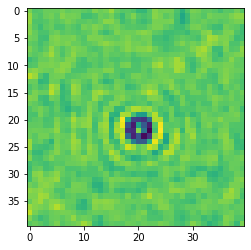

In [5]:
val = training_data.update()()
training_set = dt.Value(lambda: np.array(val)) 
(training_set >> group).update().plot()

In [6]:
generator = dt.models.autotracking.AutoTrackGenerator(
    training_set,
    3,
    (group, equivariance), 
    batch_size=8, 
    min_data_size=200, 
    max_data_size=201
)



In [7]:

with generator:
    model = dt.models.AutoMultiTracker(input_shape=(None, None, 2), num_outputs=3)
    model.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())
    model.fit(generator, epochs=50, steps_per_epoch=100)


Generating 201 / 200 samples before starting training
Epoch 1/50
100/100 [==============================] - 3s 9ms/step - total_loss: 2.6760 - consistency_loss: 1.5544
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - total_loss: 2.5393 - consistency_loss: 1.4858
Epoch 3/50
100/100 [==============================] - 1s 9ms/step - total_loss: 2.3829 - consistency_loss: 1.1135
Epoch 4/50
100/100 [==============================] - 1s 9ms/step - total_loss: 1.7054 - consistency_loss: 0.7187
Epoch 5/50
100/100 [==============================] - 1s 9ms/step - total_loss: 1.1155 - consistency_loss: 0.3284: 0s - total_loss: 1.081
Epoch 6/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.9341 - consistency_loss: 0.1790: 0s - total_loss: 0.986
Epoch 7/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.8576 - consistency_loss: 0.1197
Epoch 8/50
100/100 [==============================] - 1s 9ms/step - total_loss: 0.8320 - consistency

In [8]:
import itertools
import scipy
grid_x = 8
radius_range = np.linspace(140e-9, 350e-9, grid_x)
refractive_index_range = np.linspace(1.38, 1.6, grid_x)

num_samples = 10

data_dict = {}

for radius, refractive_index in itertools.product(radius_range, refractive_index_range):

    for _ in range(num_samples):
        image = training_data.update()(radius=radius, refractive_index=refractive_index, z=np.random.uniform(-1, 1))

        if (radius, refractive_index) not in data_dict:
            data_dict[(radius, refractive_index)] = []

        data_dict[(radius, refractive_index)].append(image)  

In [9]:
error_dict = {}
for key, value in data_dict.items():
    preds = model.predict_and_pool(np.array(value))
    error_dict[key] = np.exp(preds[:, 2])

RI, R = np.meshgrid(refractive_index_range, radius_range)

GT = R**3 * (RI - 1.33)
GT = GT[..., np.newaxis]

In [10]:
Z = np.reshape(np.array(list(error_dict.values())), (grid_x, grid_x, -1))

norm_f = GT[4, 4] / np.mean(Z[4, 4]) 
Z = Z * norm_f

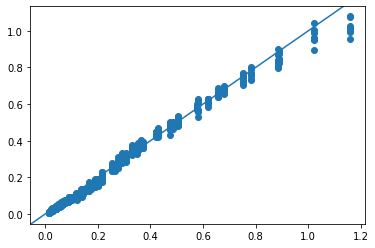

In [11]:
plt.scatter(np.repeat(GT, num_samples, -1).flatten() * 1e20, Z.flatten() * 1e20)
plt.axline((0, 0), (1, 1))
plt.show()
